In [1]:
from data_handler import vg_ob_qubo, vg_ob_qubo_baseline, vg_constr_cost_baseline    # for Vanguard 31bonds
from utils import *
from quantum_operators import Operators
from model import GPT, GPTConfig

import torch
from torch.nn import functional as F

import holoviews as hv
import hvplot.pandas
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random

from pathlib import Path
Path("./checkpoints").mkdir(parents=True, exist_ok=True)
Path("./results").mkdir(parents=True, exist_ok=True)

In [2]:
device = 'cuda'

seed = 8431907
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Prepare the Dataset and Objective function

In [3]:
n_bonds = 20
vg_raw_data = np.loadtxt(r"data/object_mat.csv", delimiter=",")[:n_bonds, :n_bonds]
vg_simplified = vg_raw_data          # no rescale
c = 2237.404382444853

max_obj = np.sum(vg_raw_data, where=vg_raw_data > 0)
min_obj = np.sum(vg_raw_data, where=vg_raw_data < 0)
penalty = (max_obj - min_obj) * 1.1

# load constrains matrix (A: (num_constr, num_bonds); b: (num_bonds,))
constr_A = np.loadtxt(r"data/constr_A.csv", delimiter=",")[:, :n_bonds]
constr_b = np.loadtxt(r"data/constr_b.csv", delimiter=",")

C_func = lambda x, vg_data: vg_ob_qubo(x, vg_data)
C_func_constr = lambda x, vg_data, A, b: vg_ob_qubo(x, vg_data) + c + penalty * np.sum(np.maximum(b - A @ x, 0)**2)

## Define Operator Pool and Distribution Function

In [4]:
# Parameters
num_max_b = 6           # number of "maximum bonds in baskets"
num_qubits = n_bonds    # number of qubits ~ bonds to be selected
num_shots = 100         # number of shots per qc
n_QAOA_layer = 100
operators = Operators(
    num_max_b = num_max_b,  # used for single/double excitations
    num_qubits = num_qubits, 
    num_shots = num_shots,
    n_QAOA_layer=n_QAOA_layer,
    n_StrongEnt_layer=50,
    n_RY=100,
    device="lightning.gpu",
)
op_types=[
        "QAOA",
    ]

op_pool = operators.generate_op_pool(
    qubo_obj=vg_simplified,
    op_types=op_types
)
op_pool_size = len(op_pool) // 2

def select_from_pool(pool, idx_list):
    """
    pool: operator pool
    idx_list: (train_size, num_layers)
    """
    idx_list_copy = idx_list.copy()
    idx_list_copy[:, 1::2] += n_QAOA_layer
    return pool[idx_list_copy]

## Tokenize

In [5]:
%%time
# Generate sequence of indices of operators in vocab
train_size = 1024
seq_len = 4
train_op_pool_inds = np.random.randint(op_pool_size, size=(train_size, seq_len))

# Corresponding sequence of operators
train_op_seq = select_from_pool(op_pool, train_op_pool_inds)

# Corresponding tokens with special starting tokens
train_token_seq = np.concatenate([
    np.zeros(shape=(train_size, 1), dtype=int), # starting token is 0
    train_op_pool_inds + 1 # shift operator inds by one
], axis=1)

# get the corresponding distributions
train_distributions = operators.get_distribution(train_op_seq)

CPU times: user 21.7 s, sys: 117 ms, total: 21.8 s
Wall time: 21.8 s


In [6]:
# Sample states
train_dictionary = operators.get_distribution(train_op_seq)
_, _, train_states=dicts_to_matrix(train_dictionary, normalize=True)
# Calculate cost
eval_cost = []
for x in train_states:
    eval_cost.append(C_func_constr(x, vg_simplified, constr_A, constr_b))
eval_cost = np.array(eval_cost)
eval_cost_mean = eval_cost.mean()
eval_cost_min = eval_cost.min()
eval_cost_max = eval_cost.max()
print(f"Cost_mean: {eval_cost_mean:.3f}, Cost_min: {eval_cost_min:.3f}, Cost_max: {eval_cost_max:.3f}", end='\r')
cost_init = np.array([eval_cost_max, eval_cost_mean, eval_cost_min])

# Training

## GPT Model

In [7]:
# !curl -O https://raw.githubusercontent.com/karpathy/nanoGPT/master/model.py

In [8]:
def cvar_from_probs(x_array, Px, alpha=0.1):
    """
    Compute CVaR from a discrete distribution with outcome values and probabilities.

    Args:
        x_array (torch.Tensor): 1D tensor of values (e.g. energies)
        Px (torch.Tensor): 1D tensor of probabilities (must sum to 1)
        alpha (float): CVaR level, e.g. 0.1 for worst 10%

    Returns:
        torch.Tensor: scalar CVaR value
    """
    # Sort values and their probabilities in ascending order of x (minimization)
    sorted_x, indices = torch.sort(x_array)
    sorted_probs = Px[indices]

    # Cumulative probability
    cum_probs = torch.cumsum(sorted_probs, dim=0)

    # Identify the tail: values contributing to worst α
    mask = cum_probs <= alpha

    # Ensure at least one value is included
    if not mask.any():
        mask[0] = True

    # Compute CVaR: average x over the α-tail, weighted by Px
    tail_probs = sorted_probs[mask]
    tail_x = sorted_x[mask]
    cvar = (tail_x * tail_probs).sum() / tail_probs.sum()

    return cvar

In [9]:
class GPTQE(GPT):
    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        return logits
    
    def calculate_loss(self, j_list, j_dictionary):
        device = j_list.device
        # calculate probabilities from GPT
        current_tokens, next_tokens = j_list[:, :-1], j_list[:, 1:]
        # calculate the logits for the next possible tokens in the sequence
        logits = self(current_tokens)
        # get the logit for the actual next token in the sequence
        next_token_mask = torch.nn.functional.one_hot(
            next_tokens, num_classes=self.config.vocab_size
        )
        next_token_logits = (logits * next_token_mask).sum(axis=2)
        # calculate the logits for the final circuit
        logits = torch.sum(next_token_logits, dim=1)
        Pj_array = torch.exp(-logits)
        # normalization
        norm=torch.sum(Pj_array)
        Pj_norm=Pj_array/norm

        # Count all x calculate Px(j)
        Pxj, _, x_arrays=dicts_to_matrix(j_dictionary, normalize=True)
        Pb=[]
        ob_x=[]
        for x in x_arrays:
            # CVaR loss
            ob=torch.tensor(C_func_constr(x, vg_raw_data, constr_A, constr_b)).to(device)   # with constraints
            ob_x.append(ob)
        ob_x=torch.tensor(ob_x).to(device)
        Px = torch.matmul(torch.from_numpy(Pxj).double().to(device), Pj_norm.double())
        # for CVaR loss
        loss=cvar_from_probs(ob_x, Px, alpha=0.1)
        # MAE loss        
        return loss

    @torch.no_grad()
    def generate(self, n_sequences, max_new_tokens, temperature=1.0, device="cpu"):
        idx = torch.zeros(size=(n_sequences, 1), dtype=int, device=device)
        total_logits = torch.zeros(size=(n_sequences, 1), device=device)
        for i in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits = self(idx_cond)
            # pluck the logits at the final step
            logits = logits[:, -1, :]
            # set the logit of the first token so that its probability will be zero
            logits[:, 0] = float("inf")
            # apply softmax to convert logits to (normalized) probabilities and scale by desired temperature
            probs = F.softmax(-logits / temperature, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # Accumulate logits
            total_logits += torch.gather(logits, index=idx_next, dim=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
        return idx, total_logits

In [10]:
tokens = torch.from_numpy(train_token_seq)
distribution = train_distributions

gpt = GPTQE(GPTConfig(
    vocab_size=op_pool_size + 1,
    block_size=seq_len,
    dropout=0.2,
    bias=False,
    n_layer = 4,
    n_head = 4,
    n_embd = 64,
)).to(device)
opt = gpt.configure_optimizers(
    weight_decay=0.05, learning_rate=1e-5, betas=(0.9, 0.999), device_type=device
)

number of parameters: 0.20M
num decayed parameter tensors: 18, with 203,328 parameters
num non-decayed parameter tensors: 9, with 576 parameters
using fused AdamW: True


In [11]:
n_batches = 128
num_epochs= 10
eval_every = 5
n_sequences=100
temperature=0.001

job_sufix = "_".join(["nqb", str(num_qubits),
                     "op", "_".join(op_types)])
job_sufix += "_cstr"

In [12]:
%%time
train_inds = np.arange(train_size)
losses = []
cost_t = [cost_init]
current_eval_cost_min = np.inf
gpt.train()
tokens = tokens.to(device)
for i in range(num_epochs): # epoch
    # Shuffle batches of the training set
    np.random.shuffle(train_inds)
    token_batches = torch.tensor_split(tokens[train_inds], n_batches)
    distribution_batches = chunks(distribution[train_inds], len(distribution) // n_batches)
    # SGD on random minibatches
    loss_record = 0
    for token_batch, distribution_batch in zip(token_batches, distribution_batches): # batch
        opt.zero_grad()
        loss = gpt.calculate_loss(token_batch, distribution_batch)
        loss.backward()
        opt.step()
        loss_record += loss.item() / n_batches
    losses.append(loss_record)
    print(f"Epoch {i}: Loss {loss_record}", end = '\r')
    
    if (i+1) % eval_every == 0:
        gpt.eval()
        # For GPT evaluation
        gen_token_seq, pred_Es = gpt.generate(
            n_sequences=n_sequences,
            max_new_tokens=seq_len,
            temperature=temperature, # Use a low temperature to emphasize the difference in logits
            device=device
        )

        # Sample circuits
        gen_inds = (gen_token_seq[:, 1:] - 1).cpu().numpy()
        gen_op_seq = select_from_pool(op_pool, gen_inds)
        
        # Sample states
        gen_dictionary = operators.get_distribution(gen_op_seq)
        _, _, gen_states=dicts_to_matrix(gen_dictionary, normalize=True)
        # Calculate cost
        eval_cost = []
        for x in gen_states:
            eval_cost.append(C_func_constr(x, vg_simplified, constr_A, constr_b))
        eval_cost = np.array(eval_cost)
        eval_cost_mean = eval_cost.mean()
        eval_cost_min = eval_cost.min()
        eval_cost_max = eval_cost.max()
        print(f"Iteration: {i+1}, Loss: {losses[-1]:.3f}, Cost_mean: {eval_cost_mean:.3f}, Cost_min: {eval_cost_min:.3f}, Cost_max: {eval_cost_max:.3f}", end='\r')
        cost_t.append(np.array([eval_cost_max, eval_cost_mean, eval_cost_min]))

        if eval_cost_min < current_eval_cost_min:
            current_eval_cost_min = eval_cost_min
            torch.save(gpt, f"./checkpoints/gqe_" + job_sufix + ".pt")
            print("\nSaved model!")
        gpt.train()

cost_t = np.vstack(cost_t)

Iteration: 5, Loss: 466737.208, Cost_mean: 1527354.278, Cost_min: 76518.379, Cost_max: 4825106.676
Saved model!
Iteration: 10, Loss: 461476.536, Cost_mean: 673466.274, Cost_min: 58508.993, Cost_max: 3743025.275
Saved model!
CPU times: user 53.2 s, sys: 156 ms, total: 53.4 s
Wall time: 53.4 s


In [13]:
loss_df = pd.DataFrame(losses)
cost_t_df = pd.DataFrame(cost_t)
loss_df.to_csv("./results/losses_" + job_sufix + ".csv", index=0)
cost_t_df.to_csv("./results/cost_t_" + job_sufix + ".csv", index=0)

:Curve   [index]   (0)
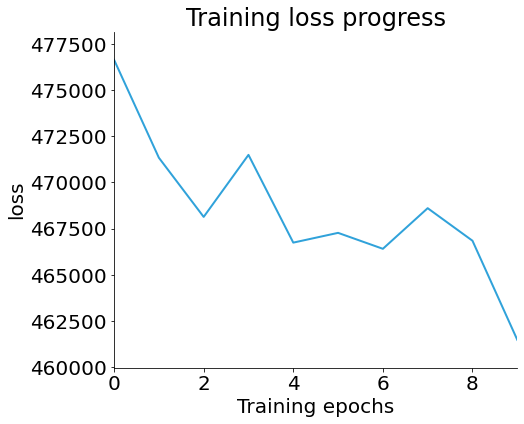

In [14]:
hvplot.extension('matplotlib')

losses = pd.read_csv("./results/losses_" + job_sufix + ".csv")["0"]
loss_fig = losses.hvplot(
    title="Training loss progress", ylabel="loss", xlabel="Training epochs", logy=False
).opts(fig_size=200, fontscale=2, aspect=1.2)
loss_fig

In [15]:
hv.save(loss_fig, 'loss_training.png', fmt='png')

:Overlay
   .Scatter.Mean_Cost       :Scatter   [Training Iterations]   (Ave Cost)
   .Curve.I                 :Curve   [Training Iterations]   (Ave Cost)
   .Area.I                  :Area   [Training Iterations]   (Min Cost,Max Cost)
   .Curve.Ground_State_Cost :Curve   [x]   (y)
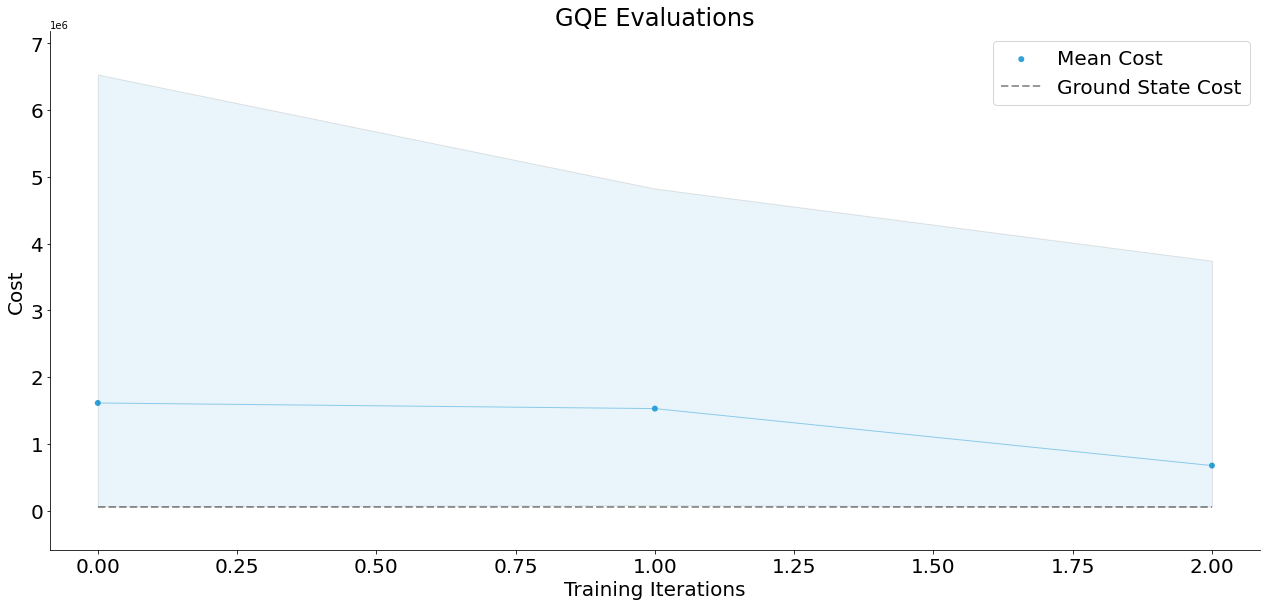

In [16]:
costs = pd.read_csv("./results/cost_t_" + job_sufix + ".csv")

baseline, prob_baseline = vg_constr_cost_baseline(vg_raw_data, c, penalty, constr_A, constr_b)

df_costs_stats = costs.reset_index()
df_costs_stats.columns = ["Training Iterations", "Max Cost", "Ave Cost", "Min Cost"]

fig = (
    df_costs_stats.hvplot.scatter(x="Training Iterations", y="Ave Cost", label="Mean Cost") *
    df_costs_stats.hvplot.line(x="Training Iterations", y="Ave Cost", alpha=0.5, linewidth=1) *
    df_costs_stats.hvplot.area(x="Training Iterations", y="Min Cost", y2="Max Cost", alpha=0.1)
)
fig = fig * hv.Curve([[0, baseline], [num_epochs // eval_every, baseline]], label="Ground State Cost").opts(color="k", alpha=0.4, linestyle="dashed")
fig = fig.opts(ylabel="Cost", title="GQE Evaluations", fig_size=600, fontscale=2)
fig

In [17]:
hv.save(fig, 'cost_training.png', fmt='png')

# Evaluation

In [18]:
bitstrings = [np.binary_repr(i, width=num_qubits) for i in range(2**num_qubits)]
def estimate_distribution(gpt, n_sequences=1024, temperature=0.001):
    gen_token_seq_, _ = gpt.generate(
    n_sequences=n_sequences,
    max_new_tokens=seq_len,
    temperature=temperature,
    device=device
    )
    gen_inds_ = (gen_token_seq_[:, 1:] - 1).cpu().numpy()
    gen_op_seq_ = select_from_pool(op_pool, gen_inds_)
    # Sample states
    gen_dictionary = operators.get_distribution(gen_op_seq_)
    Pj, gen_keys, _=dicts_to_matrix(gen_dictionary, default_value=0., normalize=True)

    Pj_sum = np.sum(Pj, axis = 1)
    Pj_norm = Pj_sum / Pj_sum.sum()
    Pj_dict = {k: v for k, v in zip(gen_keys, Pj_norm)}
    prob = []
    for k in bitstrings:
        prob.append(Pj_dict.get(k, 0))
    return prob

In [19]:
n_sequences=1024
temperature = 0.001
# # Best model
loaded = torch.load("./checkpoints/gqe_" + job_sufix + ".pt", weights_only=False)
prob_best = estimate_distribution(loaded, n_sequences=n_sequences, temperature=temperature)
prob_best = np.array(prob_best)

In [20]:
max_bin = np.array(list(np.binary_repr(np.argmax(prob_baseline), width=num_qubits)), dtype=int)
print(f"Baseline: P max = {C_func_constr(max_bin, vg_simplified, constr_A, constr_b)}")

Baseline: P max = 58508.99296865207


In [21]:
# for prob, name in zip([prob_baseline, prob_best, prob_latest], ["Baseline", "Best", "Latest"]):
for prob, name in zip([prob_baseline, prob_best], ["Baseline", "Best"]):
    print("{:>8s} model prediction: {}".format(name, np.binary_repr(np.argmax(prob), width=num_qubits)))

Baseline model prediction: 11110111111111111111
    Best model prediction: 01111011111101111101


In [22]:
prob_hamming1 = np.zeros(len(bitstrings))
for bitstring in bitstrings:
    bit_list = hamming_distance_1_neighbors(bitstring)
    bit_list += [bitstring]
    int_list = [int(i,2) for i in bit_list]
    idx = np.argmax(prob_baseline[int_list])
    prob_hamming1[int_list[idx]] += prob_best[int(bitstring,2)]

Using matplotlib backend: <object object at 0x7f14f2c9b700>


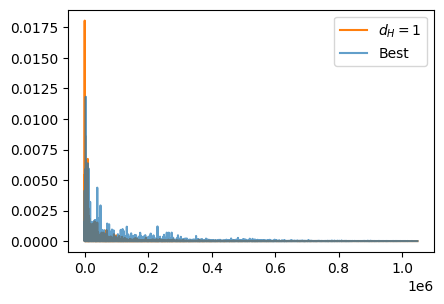

In [23]:
%matplotlib
cm = 1/2.54
# PDF plot
fig = plt.figure(figsize=(12*cm, 8*cm))
ax = fig.add_subplot(111)
sorted_idx = np.argsort(-prob_baseline)
pdf_best = np.array(prob_best)[sorted_idx]
pdf_hamming1 = np.array(prob_hamming1)[sorted_idx]
ax.plot(pdf_hamming1, label = r'$d_H=1$', c= 'tab:orange')
ax.plot(pdf_best, label='Best', c='tab:blue', alpha=0.7)
plt.legend()
fig

In [24]:
fig.savefig('pdf_hamming.png', dpi = 300, bbox_inches='tight')

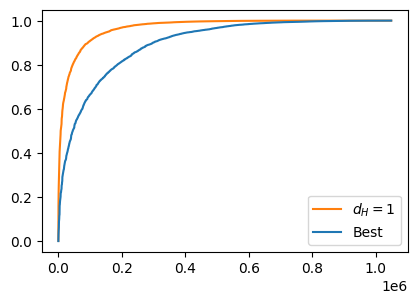

In [25]:
# PDF plot
fig = plt.figure(figsize=(12*cm, 8*cm))
ax = fig.add_subplot(111)
cdf_best = np.cumsum(pdf_best)
cdf_hamming1 = np.cumsum(prob_hamming1[sorted_idx])
ax.plot(cdf_hamming1, label = r'$d_H=1$', c= 'tab:orange')
ax.plot(cdf_best, label='Best', c='tab:blue')
plt.legend()
fig

In [26]:
fig.savefig('cdf_hamming.png', dpi = 300, bbox_inches='tight')